In [1]:
import gym_electric_motor as gem
import gym
import tensorflow as tf
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from gym.wrappers import FlattenObservation
#from tf_agents.environments.wrappers import FlattenObservationsWrapper
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common

from gym_electric_motor.visualization import MotorDashboard, ConsolePrinter
from gym_electric_motor.physical_systems import ConstantSpeedLoad

import numpy as np

/home/praneeth/anaconda3/envs/tfagents/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/praneeth/anaconda3/envs/tfagents/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/praneeth/anaconda3/envs/tfagents/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
q_generator = gem.reference_generators.WienerProcessReferenceGenerator(reference_state='i_sq')
d_generator = gem.reference_generators.WienerProcessReferenceGenerator(reference_state='i_sd')
rg = gem.reference_generators.MultipleReferenceGenerator([q_generator, d_generator])

# Change of the default motor parameters.
motor_parameter = dict(
    r_s=15e-3, l_d=0.37e-3, l_q=1.2e-3, psi_p=65.6e-3, p=3, j_rotor=0.06
)
limit_values = dict(
    i=160*1.41,
    omega=12000 * np.pi / 30,
    u=450
)
nominal_values = {key: 0.7 * limit for key, limit in limit_values.items()}
u_sup = 400
gamma = 0.99



gym_env_kwargs1 = {'visualization': MotorDashboard(plots = ['i_sq', 'i_sd', 'reward']),
            # parameterize the PMSM
               'motor_parameter' : motor_parameter,
               'limit_values' : limit_values,
               'nominal_values' : nominal_values,
               'u_sup' : u_sup,
               'load' : ConstantSpeedLoad(omega_fixed=1000 * np.pi / 30),
               #'state_filter' :['i_sq', 'i_sd', 'epsilon'],  # todo
               #'reward_weights' : {'i_sq': 1000, 'i_sd': 1000},
               #'reward_power' : 0.5,
               #'observed_states' : ['i_sq', 'i_sd'],
           
            'tau' : 1e-5 ,
                  
                  ## pass a reward function with a gamma!!  todo
            # turn off terminations via limit violation and parameterize the reward function
            'reward_function' : gem.reward_functions.WeightedSumOfErrors(observed_states=['i_sq', 'i_sd'], 
                                                                        reward_weights={'i_sq': 1, 'i_sd': 1},
                                                                        #constraint_monitor = SqdCurrentMonitor(),
                                                                        gamma = gamma,
                                                                        reward_power=1
                                                                      ),
            
            'reference_generator' : rg,
            # define a numerical solver of adequate accuracy
            'ode_solver' : 'euler' #'scipy.solve_ivp'
    
}


gym_env_kwargs2 = {'visualization': MotorDashboard(plots = ['i_sq', 'i_sd', 'reward']),
            # parameterize the PMSM
               'motor_parameter' : motor_parameter,
               'limit_values' : limit_values,
               'nominal_values' : nominal_values,
               'u_sup' : u_sup,
               'load' : ConstantSpeedLoad(omega_fixed=1000 * np.pi / 30),
               #'state_filter' :['i_sq', 'i_sd', 'epsilon'],  # todo
               #'reward_weights' : {'i_sq': 1000, 'i_sd': 1000},
               #'reward_power' : 0.5,
               #'observed_states' : ['i_sq', 'i_sd'],
           
            'tau' : 1e-5 ,
                  
                  ## pass a reward function with a gamma!!  todo
            # turn off terminations via limit violation and parameterize the reward function
            'reward_function' : gem.reward_functions.WeightedSumOfErrors(observed_states=['i_sq', 'i_sd'], 
                                                                        reward_weights={'i_sq': 1, 'i_sd': 1},
                                                                        #constraint_monitor = SqdCurrentMonitor(),
                                                                        gamma = gamma,
                                                                        reward_power=1
                                                                      ),
            
            'reference_generator' : rg,
            # define a numerical solver of adequate accuracy
            'ode_solver' : 'euler' #'scipy.solve_ivp'
    
}


In [3]:
# # Alternate way to create a tf compatible gym env

#t_env = gem.make("emotor-pmsm-disc-v1", **gym_env_kwargs1)   # define a PMSM with continuous action space
                
# t_env_f = FlattenObservation(t_env) 

# t_py_env = suite_gym.wrap_env(t_env_f, max_episode_steps=1000)
# t_tf_env = tf_py_environment.TFPyEnvironment(t_py_env)

In [4]:
env_name = "emotor-pmsm-disc-v1"
env = suite_gym.load(env_name, max_episode_steps=10000, gym_env_wrappers=[FlattenObservation],
                      gym_kwargs = gym_env_kwargs1 )  #
train_env = tf_py_environment.TFPyEnvironment(env)
# #env = FlattenObservation(env)
eval_py_env =suite_gym.load(env_name, max_episode_steps=10000, gym_env_wrappers=[FlattenObservation],
                      gym_kwargs = gym_env_kwargs2) #gem.make("emotor-pmsm-disc-v1", **gym_env_kwargs2)



eval_tf_env = tf_py_environment.TFPyEnvironment(eval_py_env)


print(env.gym)


<FlattenObservation<DiscPermanentMagnetSynchronousMotorEnvironment<emotor-pmsm-disc-v1>>>


/home/praneeth/anaconda3/envs/tfagents/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
print(train_env.time_step_spec())
print('\n \n')
eval_py_env.time_step_spec()

In [5]:
# create a neural network:

fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [6]:
# Hyper-parameters

num_iterations = 5000 

initial_collect_steps = 2000  
collect_steps_per_iteration = 1 
replay_buffer_max_length = 100000 

batch_size = 64  
learning_rate = 1e-4  
log_interval = 200 

num_eval_episodes = 10 
eval_interval = 1000

In [7]:
# instantiate DQN agent

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [8]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [9]:
# create a replay buffer

from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

replay_buffer_observer = replay_buffer.add_batch

In [10]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [11]:
from tf_agents.eval.metric_utils import log_metrics
import logging
log_metrics(train_metrics)
#logging.get_logger().set_level(logging.INFO)  
logging.getLogger().setLevel(logging.INFO)  

In [12]:
# Driver to take action steps in the environment
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics) 

In [13]:
# fill the replay buffer initially with trajectories from a random policy

from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(train_env.time_step_spec(),
                                        train_env.action_spec())
init_driver = DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(initial_collect_steps)],
    num_steps=initial_collect_steps) 
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2000/2000

In [14]:
# from tf_agents.trajectories import trajectory

# def collect_step(environment, policy, buffer):
#   time_step = environment.current_time_step()
#   action_step = policy.action(time_step)
#   next_time_step = environment.step(action_step.action)
#   traj = trajectory.from_transition(time_step, action_step, next_time_step)

#   # Add trajectory to the replay buffer
#   buffer.add_batch(traj)

# def collect_data(env, policy, buffer, steps):
#   for _ in range(steps):
#     collect_step(env, policy, buffer)

# random_policy = RandomTFPolicy(train_env.time_step_spec(),
#                                                 train_env.action_spec())
# collect_data(train_env, random_policy, replay_buffer, steps=100)

In [15]:
# dataset is sampled from the replay buffer

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset
iterator = iter(dataset)

print(iterator)

In [16]:
from tf_agents.utils.common import function

agent.train = common.function(agent.train)
collect_driver.run = function(collect_driver.run)

# Reset the train step
agent.train_step_counter.assign(0)



time_step = None
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
#iterator = iter(dataset)
loss = []
for iteration in range(num_iterations):
    time_step, policy_state = collect_driver.run(time_step, policy_state)
    trajectories, buffer_info = next(iterator)
    train_loss = agent.train(trajectories)
    loss.append(train_loss.loss.numpy())
    #t_env_f.render()
    print("\r{} loss:{:.5f}".format(
        iteration, train_loss.loss.numpy()), end="")
    if iteration % 1000 == 0:
        log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 1
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


986 loss:595.287662

INFO:absl: 
		 NumberOfEpisodes = 9
		 EnvironmentSteps = 1001
		 AverageReturn = -312.27716064453125
		 AverageEpisodeLength = 105.44444274902344


1970 loss:530.899668

INFO:absl: 
		 NumberOfEpisodes = 16
		 EnvironmentSteps = 2001
		 AverageReturn = -318.8725280761719
		 AverageEpisodeLength = 123.5


2957 loss:0.94341878

INFO:absl: 
		 NumberOfEpisodes = 20
		 EnvironmentSteps = 3001
		 AverageReturn = -315.9631042480469
		 AverageEpisodeLength = 175.39999389648438


3949 loss:0.37846476

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4001
		 AverageReturn = -323.8604431152344
		 AverageEpisodeLength = 236.8000030517578


4999 loss:0.66962405

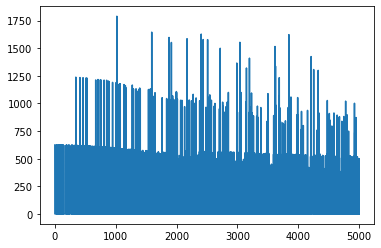

In [17]:
import matplotlib.pyplot as plt

x = range(0, num_iterations)
plt.plot(x, loss)


In [24]:
import imageio
import base64
import IPython
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [25]:
def create_policy_eval_video(policy, filename, num_episodes=1, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
        time_step = eval_tf_env.reset()
        eval_py_env.render()
        print(time_step)
        video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_tf_env.step(action_step.action)
            video.append_data(eval_py_env.render())
            
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.08333334,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.8888889 , -0.8888889 , -0.8888889 ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.7       ,
         0.7       ]], dtype=float32)>)


ValueError: append_data requires ndarray as first arg

In [21]:

policy = agent.policy
for _ in range(1):
    time_step = eval_tf_env.reset()
    print(time_step,'\n \n')
    print(train_env.time_step_spec())
    eval_py_env.render()
    
#     while not time_step.is_last():
#         action_step = policy.action(time_step)
#         time_step = eval_tf_env.step(action_step.action)
#         eval_py_env.render()

    action_step = policy.action(time_step)
    time_step = eval_tf_env.step(action_step.action)
    eval_py_env.render()


TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.08333334,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.8888889 , -0.8888889 , -0.8888889 ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.7       ,
         0.7       ]], dtype=float32)>) 
 

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(16,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.402